In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, binom
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import os
zad1_dir = "zad1"
os.makedirs(zad1_dir, exist_ok=True)
zad2_dir = "zad2"
os.makedirs(zad2_dir, exist_ok=True)
zad3_dir = "zad3"
os.makedirs(zad3_dir, exist_ok=True)
zad4_dir = "zad4"
os.makedirs(zad4_dir, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Zad 2

In [ ]:
# zad 2
# 1. próba z rozkładu
# 2. liczymy MLE (wzór trzeba na kartce policzyć)
# 3. Informacja Fishera (od MLE) - też trzeba wzór na kartce
# 4. Liczymy przedział ufności Theta_mle +- z_alpha/2 * sqrt(1/I(theta_mle)) i sprawdzamy czy prawdziwa theta jest w przedziale
# ten przedział w 4. to asymptotyczny przedział ufności
# powtarzamy to k razy (10_000) i liczymy mean tego wektora z 0 i 1 (1 jeśli prawdziwa theta jest w przedziale, 0 jeśli nie)
# no i to jest prawdopodobieństwo, że prawdziwa theta jest w przedziale ufności

# powtarzamy dla różnych n (2-100 co 1) i robimy wykres oś x - n, oś y - prawdopodobieństwo.
# Prosta linia na wysokości 0.95 powinna być widoczna
# Im większe n tym lepsze przybliżenie

# można zrobić oba przypadki parametru theta dla rozkładu beta na jednym wykresie (theta = 0.5 i theta = 5)

In [2]:
n_values = np.linspace(1, 200, 40, dtype=int)
# n_values = [20]
theta_values = [0.5, 5]
n_simulations = 10000

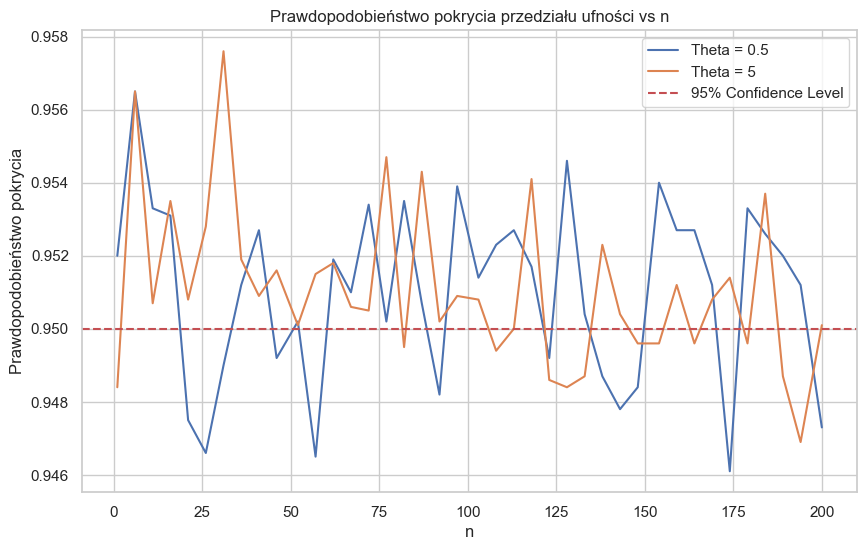

In [3]:
plt.figure(figsize=(10, 6))

for i, theta in enumerate(theta_values):
    coverage_probabilities = []
    for n in n_values:
        # 10000 wierszy, w każdym n próbek
        data = np.random.beta(theta, 1, size=(n_simulations, n))
        
        sum_log_x = np.sum(np.log(data), axis=1)
        theta_hats = -n / sum_log_x # wektor MLE długości n_simulations
        
        fisher_info = 1 / (theta_hats ** 2)  # wektor informacji Fishera długości n_simulations

        confidence_intervals_lower = theta_hats - norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))
        confidence_intervals_upper = theta_hats + norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))

        contains_theta = (confidence_intervals_lower <= theta) & (confidence_intervals_upper >= theta)

        coverage_probability = np.mean(contains_theta)
        coverage_probabilities.append(coverage_probability)

    plt.plot(n_values, coverage_probabilities, label=f'Theta = {theta}')
    
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Level')
plt.xlabel('n')
plt.ylabel('Prawdopodobieństwo pokrycia')
plt.title('Prawdopodobieństwo pokrycia przedziału ufności vs n')
plt.legend()
# plt.show()
plot_filename = os.path.join(zad2_dir, f"plots_beta.png")
plt.savefig(plot_filename, bbox_inches='tight')


In [4]:
n_values = np.linspace(1, 200, 40, dtype=int)
parameters = [(0, 1), (0, 2)]
n_simulations = 10000

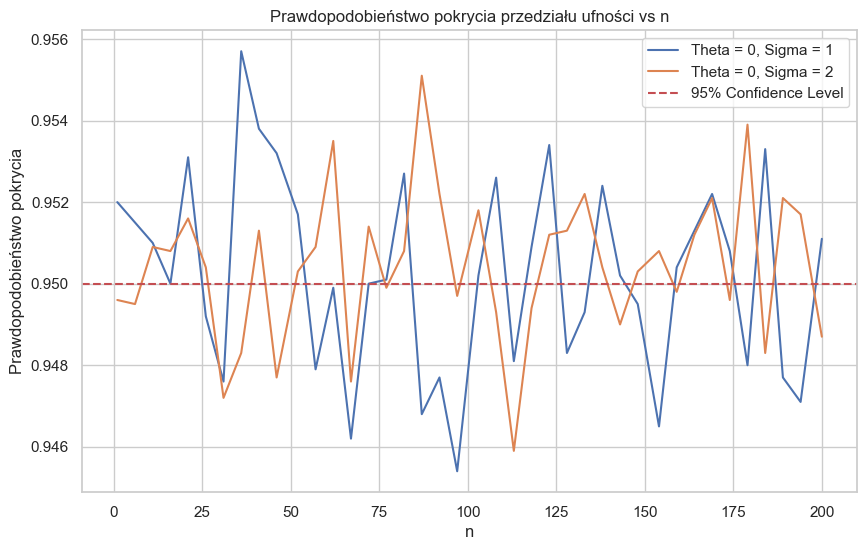

In [5]:
plt.figure(figsize=(10, 6))

for i, params in enumerate(parameters):
    theta, sigma = params
    coverage_probabilities = []
    for n in n_values:
        # 10000 wierszy, w każdym n próbek lognorm
        data = np.random.lognormal(mean=theta, sigma=sigma, size=(n_simulations, n))
        
        # wektor MLE długości n_simulations
        theta_hats = np.mean(np.log(data), axis=1)
        
        # wektor informacji Fishera długości n_simulations
        fisher_info = 1 / (sigma ** 2)

        confidence_intervals_lower = theta_hats - norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))
        confidence_intervals_upper = theta_hats + norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))

        contains_theta = (confidence_intervals_lower <= theta) & (confidence_intervals_upper >= theta)

        coverage_probability = np.mean(contains_theta)
        coverage_probabilities.append(coverage_probability)

    plt.plot(n_values, coverage_probabilities, label=f'Theta = {theta}, Sigma = {sigma}')
    
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Level')
plt.xlabel('n')
plt.ylabel('Prawdopodobieństwo pokrycia')
plt.title('Prawdopodobieństwo pokrycia przedziału ufności vs n')
plt.legend()
# plt.show()
plot_filename = os.path.join(zad2_dir, f"plots_lognorm.png")
plt.savefig(plot_filename, bbox_inches='tight')


### Zad 3

In [ ]:
# zad 3
# 1. próba z rozkładu
# 2. na tej samej próbie przedział ufności klasyczny i przedział ufności agrestiego-coull'a
# 3. sprawdzamy czy prawdziwa theta jest w przedziale
# 4. powtarzamy to k razy (10_000) i liczymy mean tego wektora z 0 i 1 (1 jeśli prawdziwa theta jest w przedziale, 0 jeśli nie)
# no i to jest prawdopodobieństwo, że prawdziwa theta jest w przedziale ufności
# dla różnych theta blisko 0 i 1

# wykres oś x - prawdziwe theta, oś y - prawdopodobieństwo pokrycia
# dwie linie - klasyczny i agrestiego-coull'a
# linia na wysokości 0.95 powinna być widoczna

In [6]:
n_values = [20, 50, 100]
theta_values = np.linspace(0.01, 0.99, 50)
n_simulations = 10000

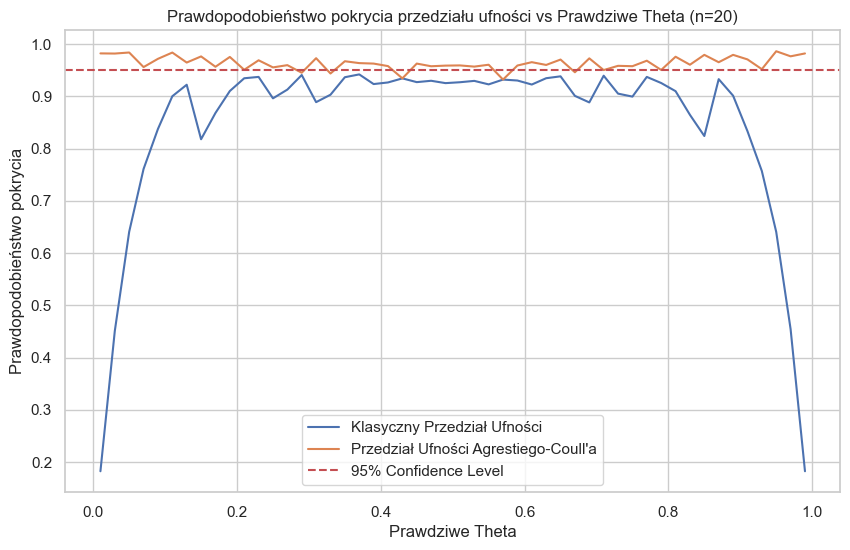

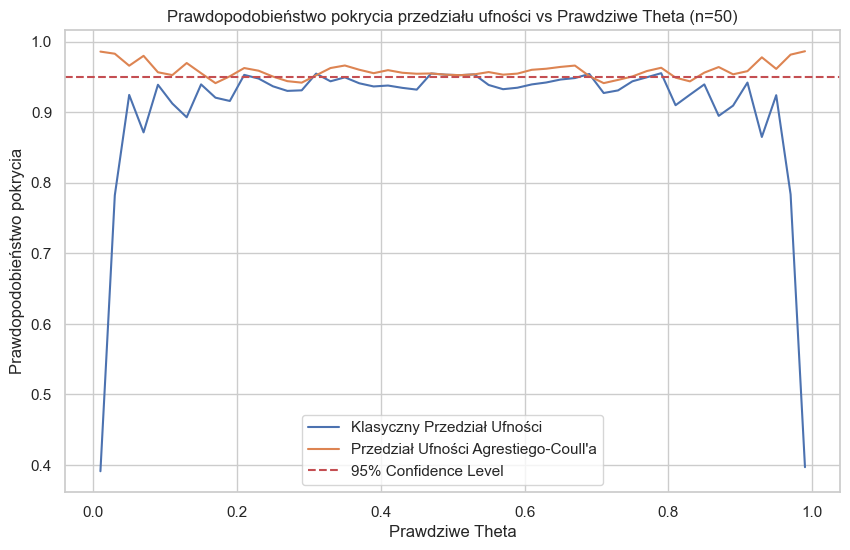

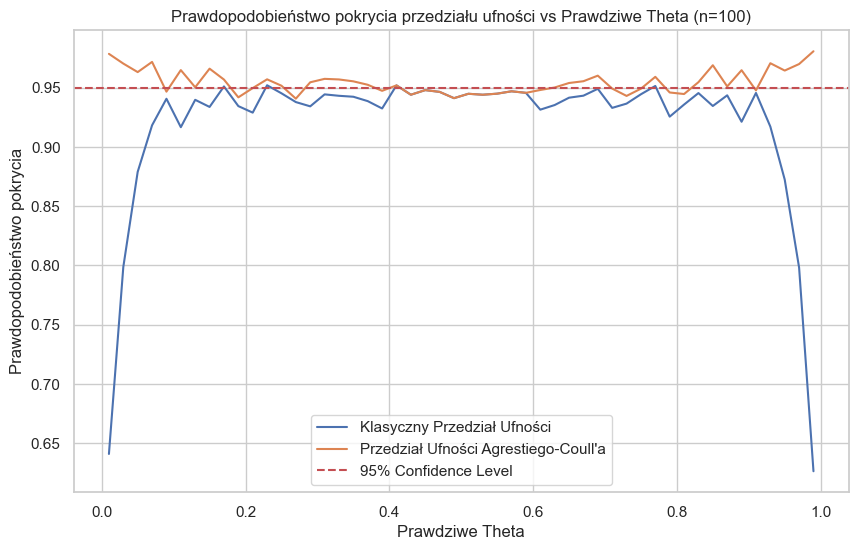

In [7]:
for n in n_values:
    classical_coverage = []
    agresti_coull_coverage = []
    
    for theta in theta_values:
        data = np.random.binomial(1, theta, size=(n_simulations, n))
        successes = np.sum(data, axis=1)
        
        # Klasyczny przedział ufności
        p_hats = successes / n
        se_classical = np.sqrt(p_hats * (1 - p_hats) / n)
        ci_lower_classical = p_hats - norm.ppf(0.975) * se_classical
        ci_upper_classical = p_hats + norm.ppf(0.975) * se_classical
        
        contains_theta_classical = (ci_lower_classical <= theta) & (ci_upper_classical >= theta)
        coverage_probability_classical = np.mean(contains_theta_classical)
        classical_coverage.append(coverage_probability_classical)
        
        # Przedział ufności Agrestiego-Coull'a
        n_tilde = n + 4
        p_tilde = (successes + 2) / n_tilde
        se_ac = np.sqrt(p_tilde * (1 - p_tilde) / n_tilde)
        ci_lower_ac = p_tilde - norm.ppf(0.975) * se_ac
        ci_upper_ac = p_tilde + norm.ppf(0.975) * se_ac
        
        contains_theta_ac = (ci_lower_ac <= theta) & (ci_upper_ac >= theta)
        coverage_probability_ac = np.mean(contains_theta_ac)
        agresti_coull_coverage.append(coverage_probability_ac)
    
    plt.figure(figsize=(10, 6))
    plt.plot(theta_values, classical_coverage, label='Klasyczny Przedział Ufności')
    plt.plot(theta_values, agresti_coull_coverage, label="Przedział Ufności Agrestiego-Coull'a")
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Level')
    plt.xlabel('Prawdziwe Theta')
    plt.ylabel('Prawdopodobieństwo pokrycia')
    plt.title(f'Prawdopodobieństwo pokrycia przedziału ufności vs Prawdziwe Theta (n={n})')
    plt.legend()
    # plt.show()
    plot_filename = os.path.join(zad3_dir, f"plots_binom_n_{n}.png")
    plt.savefig(plot_filename, bbox_inches='tight')